---
title: "Prefiltering data from PanUKB"
author: "Saikat Banerjee"
format:
  html: default
date: "2024-01-30"
file-modified: "2024-04-02"
abstract: "We read the data from PanUKB and prefilter based on heritability and effect size."

---

In [1]:
import numpy as np
import pandas as pd
import pickle
import os
from scipy import stats as sc_stats
from scipy.cluster import hierarchy as sp_hierarchy

import matplotlib.pyplot as plt
from pymir import mpl_stylesheet
from pymir import mpl_utils
mpl_stylesheet.banskt_presentation(splinecolor = 'black', dpi = 120, colors = 'kelly')
from matplotlib.gridspec import GridSpec

from nnwmf.optimize import IALM
from nnwmf.optimize import FrankWolfe, FrankWolfe_CV
from nnwmf.utils import model_errors as merr

import sys
sys.path.append("../utils/")
import histogram as mpy_histogram
import simulate as mpy_simulate
import plot_functions as mpy_plotfn

In [2]:
data_dir = "/gpfs/commons/home/sbanerjee/work/npd/PanUKB/data"
zscore_filename = f"{data_dir}/GWAS_Zscore.tsv"
trait_filename = f"{data_dir}/trait_manifest_TableS6_no_readme.tsv"
variant_filename = f"{data_dir}/allvar.pruned.closesttss.hugo"
zscore_df = pd.read_csv(zscore_filename, sep = '\t')
trait_df = pd.read_csv(trait_filename, sep = '\t')
variant_df = pd.read_csv(variant_filename, sep = '\t')

# remove extra columns from trait_df

colnames = trait_df.columns.tolist()
colnames[0] = "zindex"
trait_df.columns = colnames
trait_df_mod = trait_df.drop(labels = ['coding', 'modifier', 'coding_description', 'filename', 'aws_link'], axis=1)
#trait_df_mod

In [3]:
trait_df_mod

,zindex,trait_type,phenocode,pheno_sex,description,description_more,category,BIN_QT,n_cases_EUR,n_controls_EUR,N,Neff,estimates.final.h2_observed
0,1,icd10,A04,both_sexes,A04 Other bacterial intestinal infections,truncated: true,Chapter I Certain infectious and parasitic dis...,BIN,3088,417443.0,420531,6130.649032,0.0033
1,2,icd10,A08,both_sexes,A08 Viral and other specified intestinal infec...,truncated: true,Chapter I Certain infectious and parasitic dis...,BIN,1107,419424.0,420531,2208.171897,0.0001
2,3,icd10,A09,both_sexes,A09 Diarrhoea and gastro-enteritis of presumed...,truncated: true,Chapter I Certain infectious and parasitic dis...,BIN,9029,411502.0,420531,17670.286180,0.0035
3,4,icd10,A41,both_sexes,A41 Other septicaemia,truncated: true,Chapter I Certain infectious and parasitic dis...,BIN,5512,415019.0,420531,10879.505810,0.0011
4,5,icd10,B34,both_sexes,B34 Viral infection of unspecified site,truncated: true,Chapter I Certain infectious and parasitic dis...,BIN,2129,418402.0,420531,4236.443249,0.0003
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2478,2479,continuous,Smoking,both_sexes,"Smoking status, ever vs never",Ever (previous + current smoker) vs never base...,NaN,QT,418817,NaN,418817,418817.000000,0.1100
2479,2480,continuous,eGFR,both_sexes,"Estimated glomerular filtration rate, serum cr...",eGFR based on serum creatinine (30700) using t...,NaN,QT,401867,NaN,401867,401867.000000,0.2070
2480,2481,continuous,eGFRcreacys,both_sexes,"Estimated glomerular filtration rate, cystain C",eGFR based on cystain C (30720) using the CKD-...,NaN,QT,401570,NaN,401570,401570.000000,0.2380
2481,2482,continuous,eGFRcys,both_sexes,"Estimated glomerular filtration rate, serum cr...",eGFR based on serum creatinine (30700) and cys...,NaN,QT,402031,NaN,402031,402031.000000,0.2240


In [4]:
#| code-fold: false

zscore_df

,rsid,z1,z2,z3,z4,z5,z6,z7,z8,z9,...,z2474,z2475,z2476,z2477,z2478,z2479,z2480,z2481,z2482,z2483
0,rs6657440,-0.903532,0.561842,0.711068,-0.109174,0.223668,-1.728199,0.374988,-0.265971,-2.823282,...,1.521092,0.612532,1.405428,0.018029,0.895337,-0.008761,-2.069432,-4.292948,-4.701711,2.952899
1,rs7418179,0.398166,1.163539,0.512118,0.144794,-1.313903,-1.547410,0.450270,0.560324,-1.502268,...,-0.296537,-0.734266,-0.093081,0.412077,1.961159,0.716049,-2.171984,-5.314085,-6.612137,3.817518
2,rs80125161,-1.739115,-0.172328,0.349145,-0.329335,-0.870640,-1.004155,1.128148,0.151244,-1.816075,...,2.222433,1.092969,2.328233,1.160767,0.909524,-1.467249,-0.135785,-2.187241,-3.223529,4.508578
3,rs7524174,-0.884478,-1.762000,1.312823,-0.550764,2.132540,0.519828,0.834194,0.699441,-0.885281,...,3.356354,1.990588,3.092179,-0.133810,-0.072845,-1.376310,1.317044,0.913491,0.535188,2.245657
4,rs3829740,-1.469931,-0.519628,-0.281605,-0.267729,-1.060167,0.058116,-0.638319,-0.589767,0.228514,...,-0.320075,-0.128047,-0.524757,-0.232900,-1.051020,-0.483644,2.026508,4.400092,5.407316,1.125536
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51394,rs9616937,-0.211947,1.371231,-1.800776,0.609980,-0.619822,0.947269,-1.166021,0.478601,-0.359714,...,0.714167,0.354347,0.611158,-0.354725,1.073043,-0.831737,0.870924,1.432076,2.228501,0.536104
51395,rs1024374,0.027097,-1.817082,0.530216,0.813498,-0.076514,0.784427,1.411160,-1.111740,-0.224438,...,1.107098,1.482684,1.512723,0.322355,-0.374603,1.320194,-0.700092,-1.395039,-2.270186,0.360025
51396,rs144480800,0.545682,0.391830,0.520505,-1.280976,0.453876,-1.388940,0.025094,0.737788,1.178641,...,-0.562063,-1.148515,-0.994185,-0.268232,-0.069619,0.013256,-0.777667,-1.544760,-1.406344,2.205817
51397,rs5770994,1.441851,1.152368,-1.500000,-0.468137,-0.444156,-0.780139,-0.853550,-0.316097,0.311219,...,-1.185702,-0.624073,-0.859522,0.549669,1.809912,0.268733,0.947441,1.533302,1.658537,2.218653


# Save the full data

In [5]:
X = np.array(zscore_df.drop(labels = ['rsid'], axis = 1).values.T)
X_cent = X - np.mean(X, axis = 0, keepdims = True)

print (f"We have {X_cent.shape[0]} samples (phenotypes) and {X_cent.shape[1]} features (variants)")
print (f"Fraction of Nan entries: {np.sum(np.isnan(X)) / np.prod(X_cent.shape):.3f}")

zscore_df_filename = os.path.join(data_dir, f"modselect/zscore_all.pkl")
trait_df_filename  = os.path.join(data_dir, f"modselect/traits_all.pkl")

# zscore_df.to_pickle(zscore_df_filename)
# trait_df.to_pickle(trait_df_filename)

We have 2483 samples (phenotypes) and 51399 features (variants)
Fraction of Nan entries: 0.000


# Selection for matrix completion benchmark

In [6]:
h2_cut = 0.1
pval_cut = 5e-8

trait_df_selected = trait_df_mod[trait_df_mod['estimates.final.h2_observed'] > h2_cut]
zidx_selected = trait_df_selected['zindex'].values
colnames_selected = ['rsid'] + [f'z{x}' for x in zidx_selected]
zscore_df_selected = zscore_df[colnames_selected]
zcut = sc_stats.norm.ppf(1 - (pval_cut / 2))
rsid_idx_selected = []
for x in zidx_selected:
    rsid_idx_selected += zscore_df_selected[zscore_df_selected[f'z{x}'].abs() > zcut].index.to_list()
    
rsid_idx_selected = sorted(set(rsid_idx_selected))
zscore_df_selected = zscore_df_selected.iloc[rsid_idx_selected, :].drop(labels = ['rsid'], axis = 1)

In [7]:
X = np.array(zscore_df_selected.values.T)
X_cent = X - np.mean(X, axis = 0, keepdims = True)

print (f"We have {X_cent.shape[0]} samples (phenotypes) and {X_cent.shape[1]} features (variants)")
print (f"Fraction of Nan entries: {np.sum(np.isnan(X)) / np.prod(X_cent.shape):.3f}")

We have 216 samples (phenotypes) and 48212 features (variants)
Fraction of Nan entries: 0.000


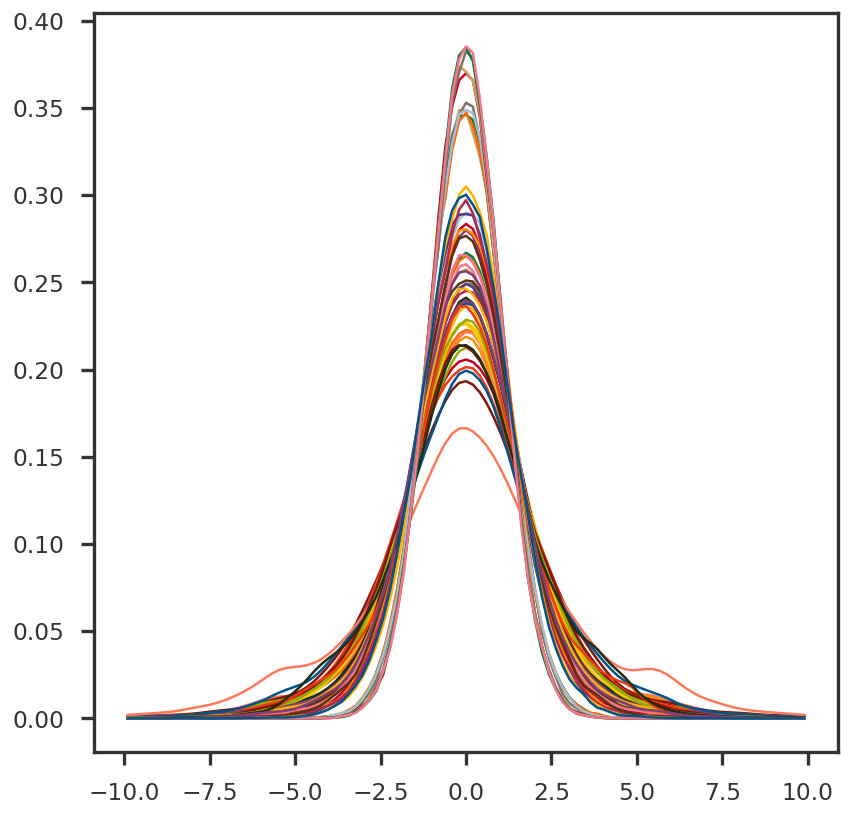

In [8]:
def get_density(x, data):
    density = sc_stats.gaussian_kde(data)
    return density.pdf(x)

def get_bins(data, nbin, xmin, xmax):
    xdelta = (np.max(data) - np.min(data)) / 10
    if not xmin: xmin = np.min(data) - xdelta
    if not xmax: xmax = np.max(data) + xdelta
    bins = np.linspace(xmin, xmax, nbin)
    xbin = [(bins[i] + bins[i+1]) / 2 for i in range(bins.shape[0] - 1)] # centers of the bins
    return xmin, xmax, bins, xbin

fig = plt.figure()
ax1 = fig.add_subplot(111)

for n in range(50):
    scores_cent = X_cent[n, :]
    xmin, xmax, bins, xbin = get_bins(scores_cent, 100, -10, 10)
    curve = get_density(xbin, scores_cent)
    ax1.plot(xbin, curve)

plt.show()

# Hierarchical clustering of covariance matrix

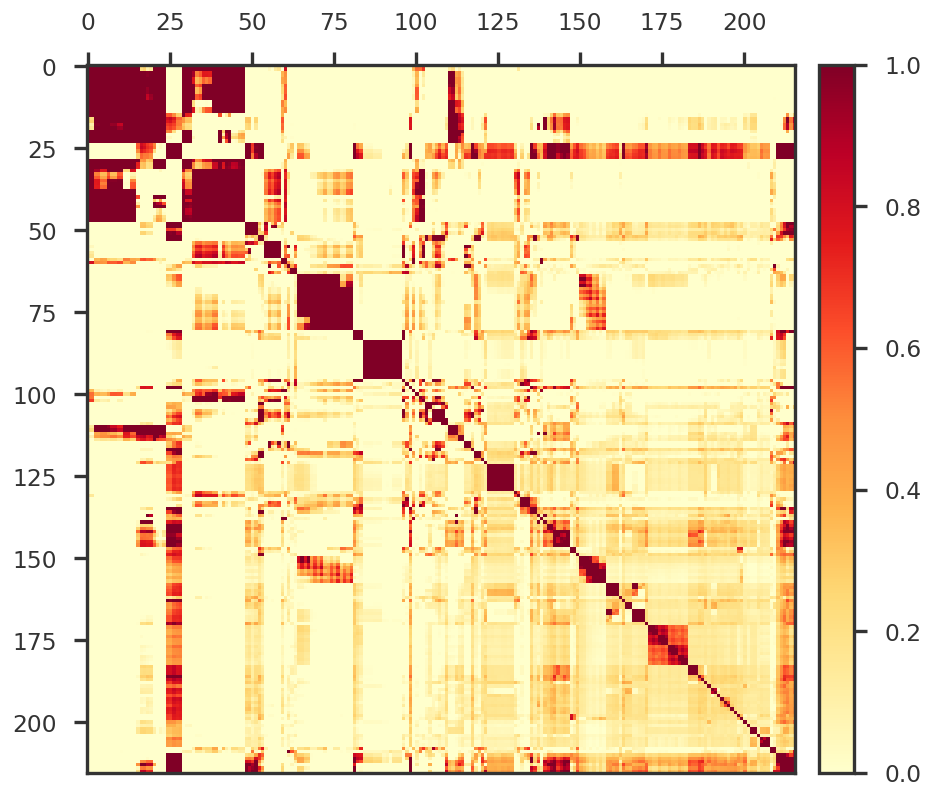

In [9]:
from scipy.cluster import hierarchy as sp_hierarchy

sample_distance_matrix = np.cov(X_cent)
o1 = sp_hierarchy.leaves_list(sp_hierarchy.linkage(sample_distance_matrix, method = 'centroid'))

fig = plt.figure(figsize = (8, 8))
ax1 = fig.add_subplot(111)
                                            
#mpy_plotfn.plot_covariance_heatmap(ax1, Z * np.sqrt(p) / np.sqrt(nsample))
mpy_plotfn.plot_covariance_heatmap(ax1, X_cent[o1, :])

plt.tight_layout()
plt.show()

# Save the dataframes

In [10]:
zscore_df_selected_filename = os.path.join(data_dir, f"modselect/zscore_h2{h2_cut}_pval{pval_cut}.pkl")
trait_df_selected_filename  = os.path.join(data_dir, f"modselect/traits_h2{h2_cut}.pkl")

# zscore_df_selected.to_pickle(zscore_df_selected_filename)
# trait_df_selected.to_pickle(trait_df_selected_filename)

In [11]:
zscore_df_selected

,z1415,z1678,z1679,z1680,z1681,z1682,z1683,z1685,z1686,z1687,...,z2473,z2474,z2475,z2476,z2477,z2479,z2480,z2481,z2482,z2483
0,3.591973,-0.038545,4.356103,-0.030974,-2.625193,-0.082182,-1.513514,2.927977,1.145769,-0.924589,...,-0.964337,1.521092,0.612532,1.405428,0.018029,-0.008761,-2.069432,-4.292948,-4.701711,2.952899
1,2.690253,2.060959,5.074098,2.131896,-2.200532,0.203585,0.053289,2.081926,1.606040,-0.265317,...,-0.158982,-0.296537,-0.734266,-0.093081,0.412077,0.716049,-2.171984,-5.314085,-6.612137,3.817518
2,4.672697,1.966395,6.363325,1.017074,-3.506709,-0.985765,-0.432902,2.834796,3.055340,-2.151471,...,0.716255,2.222433,1.092969,2.328233,1.160767,-1.467249,-0.135785,-2.187241,-3.223529,4.508578
3,3.628734,0.377612,1.851399,-1.249221,-1.881565,-0.479096,-1.015920,0.498607,-0.294269,-1.046150,...,-1.404276,3.356354,1.990588,3.092179,-0.133810,-1.376310,1.317044,0.913491,0.535188,2.245657
4,-0.858911,-0.623239,-1.686601,-3.003435,0.532031,-0.341693,-3.777505,0.254496,0.226082,-0.322407,...,-0.536635,-0.320075,-0.128047,-0.524757,-0.232900,-0.483644,2.026508,4.400092,5.407316,1.125536
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51394,1.342127,1.797208,-0.979370,-1.867291,0.037906,-1.162637,-3.256483,2.176569,-1.732998,-0.328859,...,0.482023,0.714167,0.354347,0.611158,-0.354725,-0.831737,0.870924,1.432076,2.228501,0.536104
51395,-1.244520,-1.527636,1.849772,2.144946,-0.031816,2.274951,2.456148,-2.560491,-0.212461,0.982478,...,-0.110369,1.107098,1.482684,1.512723,0.322355,1.320194,-0.700092,-1.395039,-2.270186,0.360025
51396,-0.253862,0.812630,-0.711050,1.179577,-2.862653,-2.013295,2.833169,0.153290,2.138158,-2.653582,...,-0.088946,-0.562063,-1.148515,-0.994185,-0.268232,0.013256,-0.777667,-1.544760,-1.406344,2.205817
51397,-0.915597,1.668377,-0.823597,0.163447,-0.061726,0.319698,0.922030,2.559199,0.215736,0.468609,...,0.098326,-1.185702,-0.624073,-0.859522,0.549669,0.268733,0.947441,1.533302,1.658537,2.218653


**MHC region** (hg38)

Chromosome 6: 28510120 - 33480577

In [12]:
variant_df.query('chr == 6 and 28510120 < pos < 33480577')

,SNP,chr,pos,ref,alt,rsid,varid,maf_EUR,name_1kg,tie,Gene_name,hgnc_id,name,omim_id,notfound,ensembl_gene_id


# Save all traits excluding prescriptions

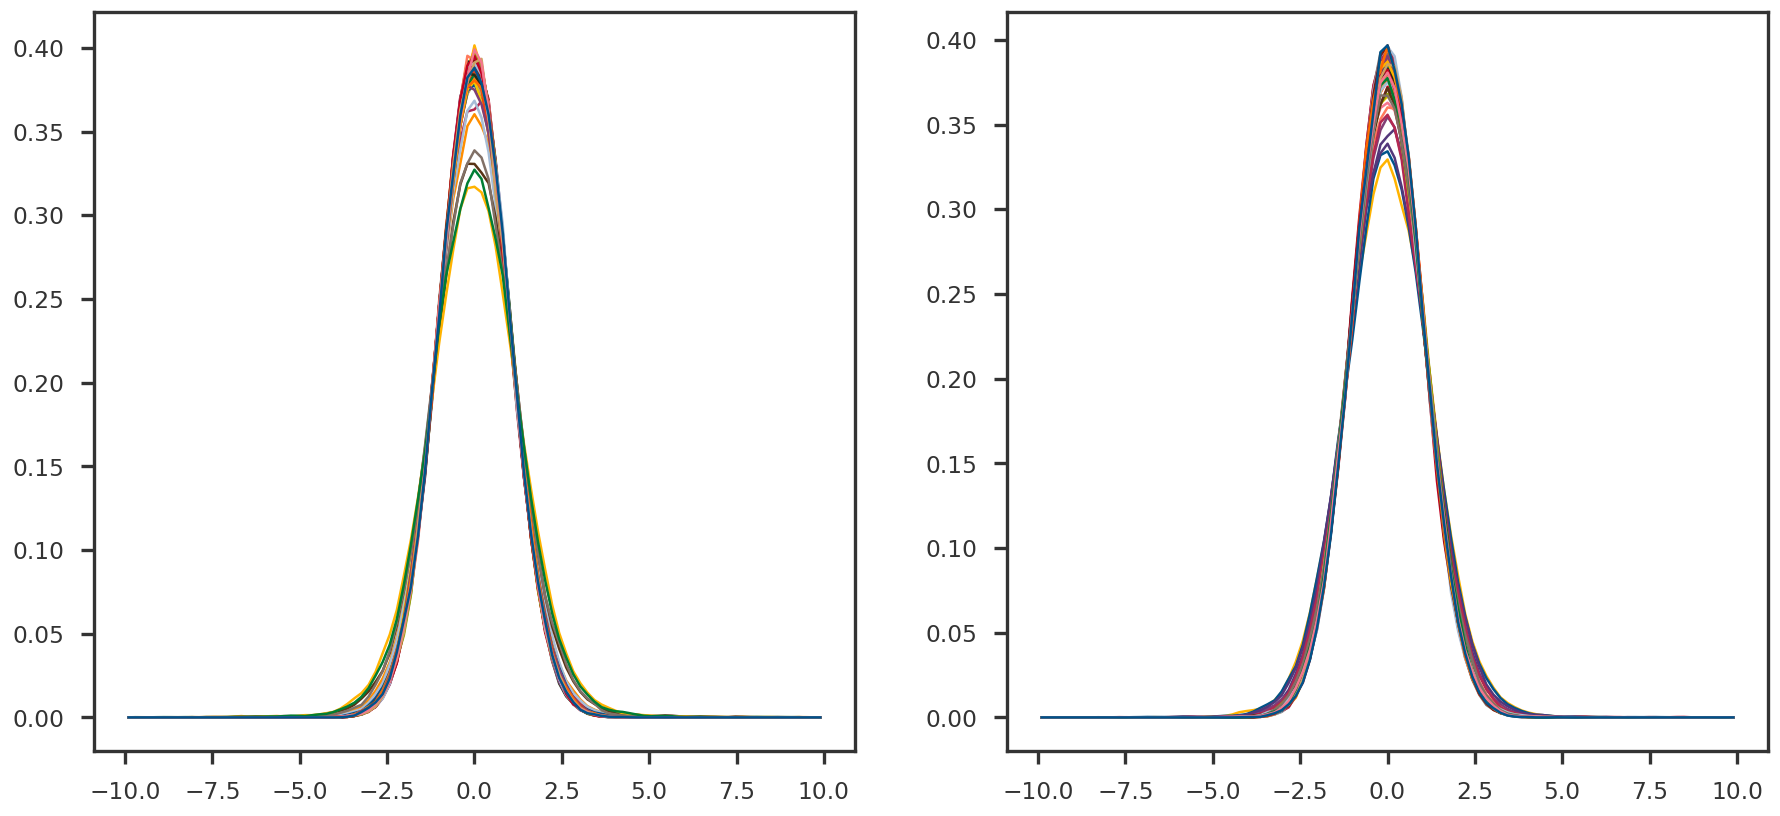

In [39]:
zscore_df_noRx = zscore_df[[f'z{x}' for x in trait_df.query('trait_type != "prescriptions"')['zindex'].values]]
zscore_df_Rx   = zscore_df[[f'z{x}' for x in trait_df.query('trait_type == "prescriptions"')['zindex'].values]]

X_Rx = np.array(zscore_df_Rx.values.T)
X_Rx_cent = X_Rx - np.mean(X_Rx, axis = 0, keepdims = True)

X_noRx = np.array(zscore_df_noRx.values.T)
X_noRx_cent = X_noRx - np.mean(X_noRx, axis = 0, keepdims = True)

fig = plt.figure(figsize = (18, 8))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

for n in range(50):
    scores_cent = X_noRx[n, :]
    xmin, xmax, bins, xbin = get_bins(scores_cent, 100, -10, 10)
    curve = get_density(xbin, scores_cent)
    ax1.plot(xbin, curve)
    
for n in range(50):
    scores_cent = X_Rx[n, :]
    xmin, xmax, bins, xbin = get_bins(scores_cent, 100, -10, 10)
    curve = get_density(xbin, scores_cent)
    ax2.plot(xbin, curve)    

plt.show()

In [49]:
pval_cut = 5e-8

trait_df_noRx = trait_df.query('trait_type != "prescriptions"')
zidx_noRx     = trait_df_noRx['zindex'].values

# from the zscore_df, select columns corresponding to _noRx traits
colnames_noRx = [f'z{x}' for x in zidx_noRx]
zscore_df_noRx = zscore_df[colnames_noRx]

# Remove SNPs which are not significant in at least one trait
zcut = sc_stats.norm.ppf(1 - (pval_cut / 2))
zscore_df_noRx = zscore_df_noRx[(zscore_df_noRx.abs() >= zcut).any(axis = 1)]


# Save the dataframes for next step
zscore_df_noRx_filename = os.path.join(data_dir, f"modselect/zscore_noRx.pkl")
trait_df_noRx_filename  = os.path.join(data_dir, f"modselect/traits_noRx.pkl")
# zscore_df_noRx.to_pickle(zscore_df_noRx_filename)
# trait_df_noRx.to_pickle(trait_df_noRx_filename)

In [50]:
zscore_df = pd.read_pickle(os.path.join(data_dir, f"modselect/zscore_all.pkl"))
trait_df  = pd.read_pickle(os.path.join(data_dir, f"modselect/traits_all.pkl"))

In [52]:
zscore_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51399 entries, 0 to 51398
Columns: 2484 entries, rsid to z2483
dtypes: float64(2483), object(1)
memory usage: 974.1+ MB


In [53]:
trait_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2483 entries, 0 to 2482
Data columns (total 18 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   zindex                       2483 non-null   int64  
 1   trait_type                   2483 non-null   object 
 2   phenocode                    2483 non-null   object 
 3   pheno_sex                    2483 non-null   object 
 4   coding                       267 non-null    object 
 5   modifier                     394 non-null    object 
 6   description                  2110 non-null   object 
 7   description_more             1408 non-null   object 
 8   coding_description           261 non-null    object 
 9   category                     2304 non-null   object 
 10  BIN_QT                       2483 non-null   object 
 11  n_cases_EUR                  2483 non-null   int64  
 12  n_controls_EUR               1677 non-null   float64
 13  N                 